In [120]:
import torch
import random
import os
import time
import tqdm

import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt


torch.__version__

'2.2.2'

In [2]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [81]:
class RecipeImageDataset(data.Dataset):
    def __init__(self, path, transform=None, shuffle=False):
        self.path = path
        self.shuffle = shuffle
        self.transform = transform
        self.images = list()
        for img in os.listdir(path):
            try:
                p = os.path.join(path, img)
                Image.open(p)
                self.images.append(p)
            except Exception:
                pass
        if shuffle:
            random.shuffle(self.images)
            
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
        
    def __repr__(self)->str:
        return "RecipeImageDataset"
    def __str__(self)->str:
        return 'RecipeImageDataset'


In [82]:
mean = std = .5

image_transforms = {
    "train": transforms.Compose([
       transforms.Resize([96,96]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.RandomCrop(96, padding=2),
       transforms.ToTensor(),
       transforms.Grayscale(
         num_output_channels = 1
       ),
       transforms.Normalize(mean=[mean], std=[std], inplace=False)                         
    ]),
    "test": transforms.Compose([
        transforms.Resize([96,96]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ])
}

In [83]:
base_dir = "recipe_images"

train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'test')

In [84]:
train_dataset = RecipeImageDataset(
    train_path,
    transform = image_transforms['train'],
    shuffle=True
)
test_dataset = RecipeImageDataset(
    test_path,
    transform = image_transforms['test'],
    shuffle=False
)

In [85]:
train_dataset[0]

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.2673, -0.1719, -0.0343,  ...,  0.8796, -1.0000, -1.0000],
         [-0.1772,  0.1590,  0.1293,  ...,  0.8874, -1.0000, -1.0000],
         [-0.0749, -0.0522, -0.2217,  ...,  0.8828, -1.0000, -1.0000]]])

In [86]:
len(train_dataset), len(test_dataset)

(2398, 595)

In [87]:
def plot_images(images, cols=5):
  rows = 4
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, image in enumerate(images):
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(image.view(96, 96), cmap="gray")
      plt.title("Image {}".format(i+1), color ='k', fontsize=8 )

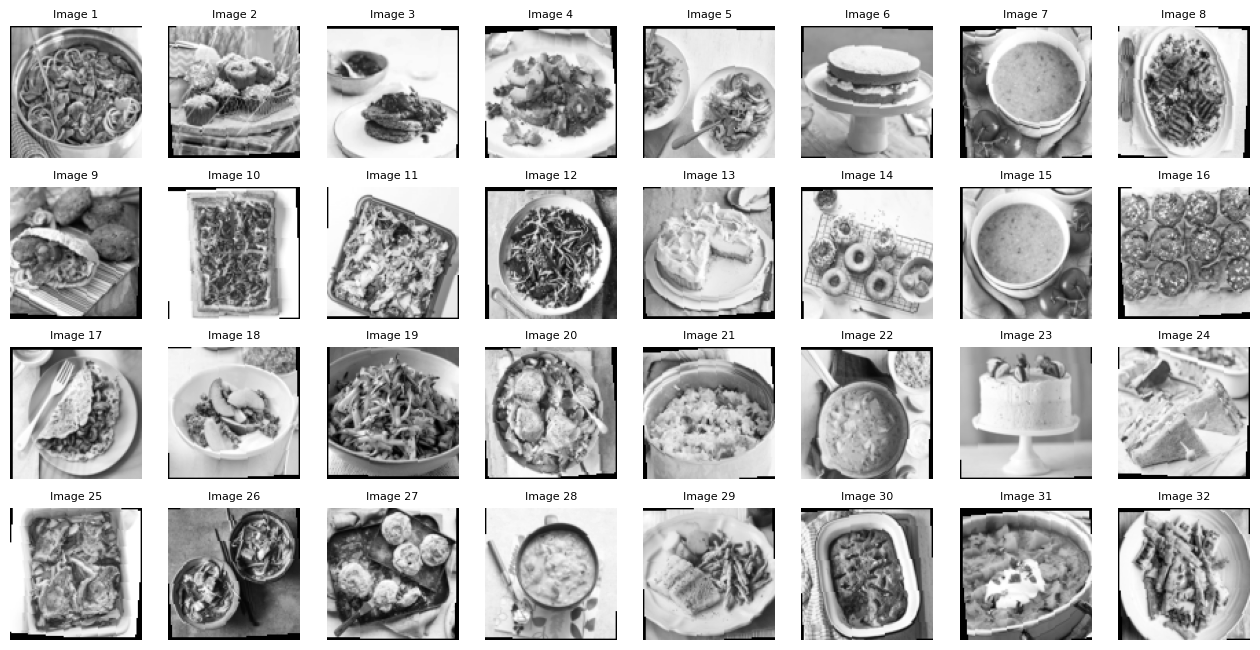

In [90]:
plot_images([train_dataset[i] for i in range(32)],  cols=8)

In [104]:
BATCH_SIZE = 50
train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_dataset,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )

In [114]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 250),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(250, 100),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(100, output_dim)
    )

  def forward(self, x):
    # x = [batch size, height, width]
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    # x = [batch size, height * width]
    x = self.classifier(x) # x = [batch_size, output_dim]
    return x

In [115]:
INPUT_DIM = 96 * 96
OUTPUT_DIM = 10
dropout = .5
features_mlp = MLP(INPUT_DIM, OUTPUT_DIM, dropout).to(device)
features_mlp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [134]:
def feature_reduction(iterator, device):
    images = []
    features = []
    for X in tqdm.tqdm(iterator, desc="feature reduction..."):
        X = X.to(device)
        preds = features_mlp(image)
        images.append(X.cpu())
        features.append(preds.detach().cpu())
    images = torch.cat(images, dim = 0).numpy()
    features = torch.cat(features, dim = 0).detach().numpy()
    return images, features

In [135]:
train_images, train_features = feature_reduction(train_iterator, device=device)
test_images, test_features = feature_reduction(test_iterator, device=device)

feature reduction...: 100%|████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.13it/s]


In [137]:
train_features[:2]

array([[ 0.21156678,  0.16301826,  0.23049015,  0.03519581, -0.02892931,
         0.00491375,  0.08884146, -0.10866977,  0.06638309,  0.20535408],
       [ 0.07775945,  0.03504328,  0.09478074,  0.1209719 , -0.03811824,
         0.14484076, -0.05425697,  0.11283609, -0.06793033,  0.07956771]],
      dtype=float32)

In [146]:
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=10)
kmeans.fit(train_features)

C:\Users\crisp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=42)

In [147]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 2])

In [148]:
set(kmeans.labels_)

{0, 1, 2}

In [149]:
from collections import Counter
Counter(kmeans.labels_)

Counter({2: 877, 0: 774, 1: 749})

In [150]:
kmeans.score(train_features)

-203.78497314453125

In [151]:
kmeans.score(test_features)

-51.179630279541016

In [154]:
Counter(kmeans.predict(test_features))

Counter({2: 205, 0: 203, 1: 192})

In [160]:
n = 150
y = [i.mean() for i in train_features[:n]]
x = np.arange(n)
c = kmeans.labels_[:n]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


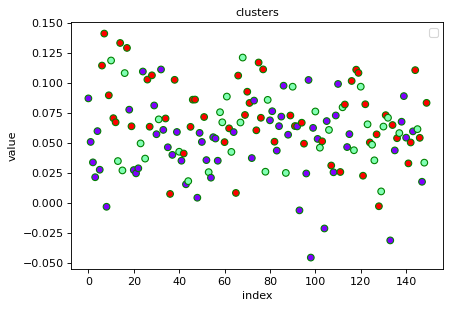

In [161]:
plt.figure(figsize=(6, 4), dpi=80)
scatter = plt.scatter(x, y, c=c, cmap='rainbow', edgecolor="g")
plt.title("clusters", color="k", fontsize=10)
plt.xlabel("index", fontsize=10)
plt.ylabel("value", fontsize=10)
plt.legend()
plt.show()